# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [3]:
anime = pd.read_csv('data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
ratings = pd.read_csv('data/anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет. 

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут. 

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее. 

### 1. Избавьтесь от -1

In [5]:
ratings = pd.read_csv('data/anime/rating.csv.zip')

ratings = ratings[ratings['rating'] != -1]

print(f"Размер датасета после удаления -1: {ratings.shape}")
print(ratings.head())

Размер датасета после удаления -1: (6337241, 3)
     user_id  anime_id  rating
47         1      8074      10
81         1     11617      10
83         1     11757      10
101        1     15451      10
153        2     11771      10


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ \operatorname{erfc}(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

`erfc` — это дополнительная функция ошибок Гаусса. [wiki](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA)

$$\operatorname{erfc}\,x = 1-\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}} \int\limits_x^{\infty} e^{-t^2}\,\mathrm dt$$

$$\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}}\int\limits_0^x e^{-t^2}\,\mathrm dt$$

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn. 

In [6]:
import numpy as np
from scipy.special import erfc

def chauvenet(array):
    array = np.asarray(array)  
    mean = np.mean(array)      
    std_dev = np.std(array)    
    N = len(array)             
    
    deviation = np.abs(array - mean) / std_dev
    
    prob = erfc(deviation / np.sqrt(2))
    
    threshold = 1.0 / (2 * N)
    
    mask = prob >= threshold
    
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [7]:
count_reviews = ratings.groupby('user_id')['anime_id'].count()

count_reviews = count_reviews.to_frame(name='count_anime_watched')

print(count_reviews.head())

         count_anime_watched
user_id                     
1                          4
2                          1
3                         92
5                        459
7                        343


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [8]:
mask = chauvenet(count_reviews['count_anime_watched'].values)

outlier_users = count_reviews[~mask]

print(outlier_users)

         count_anime_watched
user_id                     
226                      742
446                      743
478                      863
958                      783
1145                     904
...                      ...
70953                    830
71792                   1014
73135                    986
73234                    812
73378                    723

[550 rows x 1 columns]


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**

In [9]:
bad_user_threshold = outlier_users['count_anime_watched'].min()
print("Порог bad_user_threshold:", bad_user_threshold)
filtered_users = count_reviews[count_reviews['count_anime_watched'] < bad_user_threshold]
print("Количество пользователей после фильтрации:", len(filtered_users))

Порог bad_user_threshold: 701
Количество пользователей после фильтрации: 69050


In [19]:
//* 1: outlier_users 
Это пользователи, у которых аномально большое количество просмотренных аниме по сравнению с остальными пользователями в датасете.
//* 2: Критерий Шавене основывается на стандартном распределении данных. 
Если значение сильно отклоняется от среднего (выражается через количество стандартных отклонений), 
то вероятность наблюдения таких данных становится очень низкой.
В нашем случае пользователи, которые посмотрели аномально много аниме (в несколько раз больше среднего по выборке), 
попадают под это определение. Это делает их выбросами, так как они не соответствуют типичному поведению большинства пользователей.
//* 3: Такие пользователи, скорее всего:
- Очень активны и уже просмотрели значительное количество контента.
- Вполне возможно, что они не нуждаются в рекомендациях, так как уже изучили большую часть доступного каталога аниме.
- Их потребности выходят за рамки типичных пользователей, для которых и предназначена рекомендательная система.
Таким образом, им не требуется классическая рекомендательная система, поскольку они действуют иначе и могут быть исключением.


SyntaxError: invalid syntax (837177808.py, line 1)

Если все было правильно `bad_user_threshold` больше 500. 

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [10]:
count_reviews.rename(columns={'count_anime_watched': 'count_reviews'}, inplace=True)
ratings = ratings.merge(count_reviews, on='user_id', how='left')
ratings = ratings[ratings['count_reviews'] < bad_user_threshold]

print(ratings.head())
print(f"Размер таблицы после фильтрации: {ratings.shape}")

   user_id  anime_id  rating  count_reviews
0        1      8074      10              4
1        1     11617      10              4
2        1     11757      10              4
3        1     15451      10              4
4        2     11771      10              1
Размер таблицы после фильтрации: (5804470, 4)


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [11]:
median_count = ratings['count_reviews'].median()
print(f"Медиана количества просмотров: {median_count}")

ratings = ratings[ratings['count_reviews'] >= median_count]

ratings = ratings.drop(columns=['count_reviews'])

print("Строк после удаления:", len(ratings))
print(ratings.head())

Медиана количества просмотров: 180.0
Строк после удаления: 2914542
     user_id  anime_id  rating
97         5         6       8
98         5        15       6
99         5        17       6
100        5        18       6
101        5        20       6


In [ ]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])

Теперь рассмотрим таблицу `anime`. 


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [12]:
mask_rating = chauvenet(anime['rating'].values)
mask_members = chauvenet(anime['members'].values)

mask = mask_rating & mask_members

outlier_anime = anime[~mask]
print(f"Выбросы: {outlier_anime}")

anime = anime.drop(outlier_anime.index)

Выбросы:                                         name  \
anime_id                                       
5114        Fullmetal Alchemist: Brotherhood   
9253                             Steins;Gate   
11061                 Hunter x Hunter (2011)   
4181                    Clannad: After Story   
918                                  Gintama   
...                                      ...   
2476                             School Days   
13405                     Utsu Musume Sayuri   
3287            Tenkuu Danzai Skelter+Heaven   
34476     Platonic Chain: Ansatsu Jikkouchuu   
20007          Hi Gekiga Ukiyoe Senya Ichiya   

                                                      genre     type episodes  \
anime_id                                                                        
5114      Action, Adventure, Drama, Fantasy, Magic, Mili...       TV       64   
9253                                       Sci-Fi, Thriller       TV       24   
11061               Action, Adventure, Sho

### 9. Ответье на вопросы

#### Что критерий посчитал выбросом? 

#### Почему критерий посчитал их выбросом? 

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе? 

**Ответы:**

In [17]:
//* 1: Выбросами считаются аниме с аномально низкими или высокими рейтингами и количеством участников.
//* 2: Из-за крайне низких или высоких значений, что отличается от нормальных показателей для большинства аниме.
//* 3: Аниме с высокими оценками полезны для рекомендаций, а с низкими — могут быть исключены, 
но в некоторых случаях могут подходить для нишевых рекомендаций в зависимости от интересов пользователя.

SyntaxError: invalid syntax (3311301227.py, line 1)

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы. 

In [13]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [14]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Comedy, Drama, School, Shounen, Sports' 'Drama, Military, Sci-Fi, Space'
 'Drama, School, Shounen'
 'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural'
 'Fantasy, Slice of Life' 'Comedy, Drama, Shounen, Sports'
 'Action, Drama, Historical, Martial Arts, Romance, Samurai'
 'Comedy, Mystery, Romance, School, Sci-Fi, Supernatural']
len= 3182

Genres=['Parody', 'Demons', 'Shounen Ai', 'Military', 'Sci-Fi', 'Yuri', 'Josei', 'Music', 'Shoujo Ai', 'Thriller', 'Romance', 'Mystery', 'Horror', 'Hentai', 'Slice of Life', 'Mecha', 'Drama', 'Historical', 'Action', 'Space', 'Ecchi', 'Shoujo', 'Psychological', 'Magic', 'Game', 'Martial Arts', 'Kids', 'Comedy', 'Seinen', 'Harem', 'Samurai', 'Sports', 'Cars', 'Fantasy', 'Police', 'Dementia', 'Yaoi', 'Shounen', 'Adventure', 'Super Power', 'Vampire', 'Supernatural', 'School']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [15]:
one_hot_genres = pd.DataFrame(0, index=anime.index, columns=genres)

for idx, row in anime.iterrows():
    genres_for_anime = genre_splitter(row['genre'])
    one_hot_genres.loc[idx, genres_for_anime] = 1

print(one_hot_genres.head())

          Parody  Demons  Shounen Ai  Military  Sci-Fi  Yuri  Josei  Music  \
anime_id                                                                     
32281          0       0           0         0       0     0      0      0   
28977          1       0           0         0       1     0      0      0   
9969           1       0           0         0       1     0      0      0   
32935          0       0           0         0       0     0      0      0   
820            0       0           0         1       1     0      0      0   

          Shoujo Ai  Thriller  ...  Police  Dementia  Yaoi  Shounen  Shounen  \
anime_id                       ...                                             
32281             0         0  ...       0         0     0        0        0   
28977             0         0  ...       0         0     0        1        1   
9969              0         0  ...       0         0     0        1        1   
32935             0         0  ...       0         0 

Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [16]:
# Выберем случайные 10% пользователей
unique_users = ratings['user_id'].unique()
sample_users = pd.Series(unique_users).sample(frac=0.1, random_state=42)

# Отфильтруем рейтинги только для этих пользователей
small_ratings = ratings[ratings['user_id'].isin(sample_users)]

# Выполним объединение
df = small_ratings.merge(one_hot_genres, on='anime_id', how='left')
df.head()


,user_id,anime_id,rating,Parody,Demons,Shounen Ai,Military,Sci-Fi,Yuri,Josei,...,Police,Dementia,Yaoi,Shounen,Shounen,Adventure,Super Power,Vampire,Supernatural,School
0,5,6,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,15,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5,17,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5,18,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,20,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [17]:
import numpy as np

df.replace(0, np.nan, inplace=True)
df = df.groupby('user_id').mean()

df.head()

,anime_id,rating,Parody,Demons,Shounen Ai,Military,Sci-Fi,Yuri,Josei,Music,...,Police,Dementia,Yaoi,Shounen,Shounen,Adventure,Super Power,Vampire,Supernatural,School
user_id,,,,,,,,,,,,,,,,,,,,,
5,10940.472767,4.355120,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,...,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21,10731.911111,7.622222,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,...,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
160,3653.234339,8.192575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
235,9446.172161,7.260073,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,...,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
261,10527.660377,7.611321,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [18]:
df.fillna(-1, inplace=True)
df.head()

,anime_id,rating,Parody,Demons,Shounen Ai,Military,Sci-Fi,Yuri,Josei,Music,...,Police,Dementia,Yaoi,Shounen,Shounen,Adventure,Super Power,Vampire,Supernatural,School
user_id,,,,,,,,,,,,,,,,,,,,,
5,10940.472767,4.355120,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21,10731.911111,7.622222,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
160,3653.234339,8.192575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
235,9446.172161,7.260073,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
261,10527.660377,7.611321,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

df.head()

,anime_id,rating,Parody,Demons,Shounen Ai,Military,Sci-Fi,Yuri,Josei,Music,...,Police,Dementia,Yaoi,Shounen,Shounen,Adventure,Super Power,Vampire,Supernatural,School
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.482656,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,0.473028,0.578773,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
160,0.146220,0.679812,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
235,0.413668,0.514617,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
261,0.463598,0.576841,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [20]:
from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df)

user_clusters = kmeans.labels_

print(user_clusters[:10])

[4 0 7 4 8 4 4 0 0 3]


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

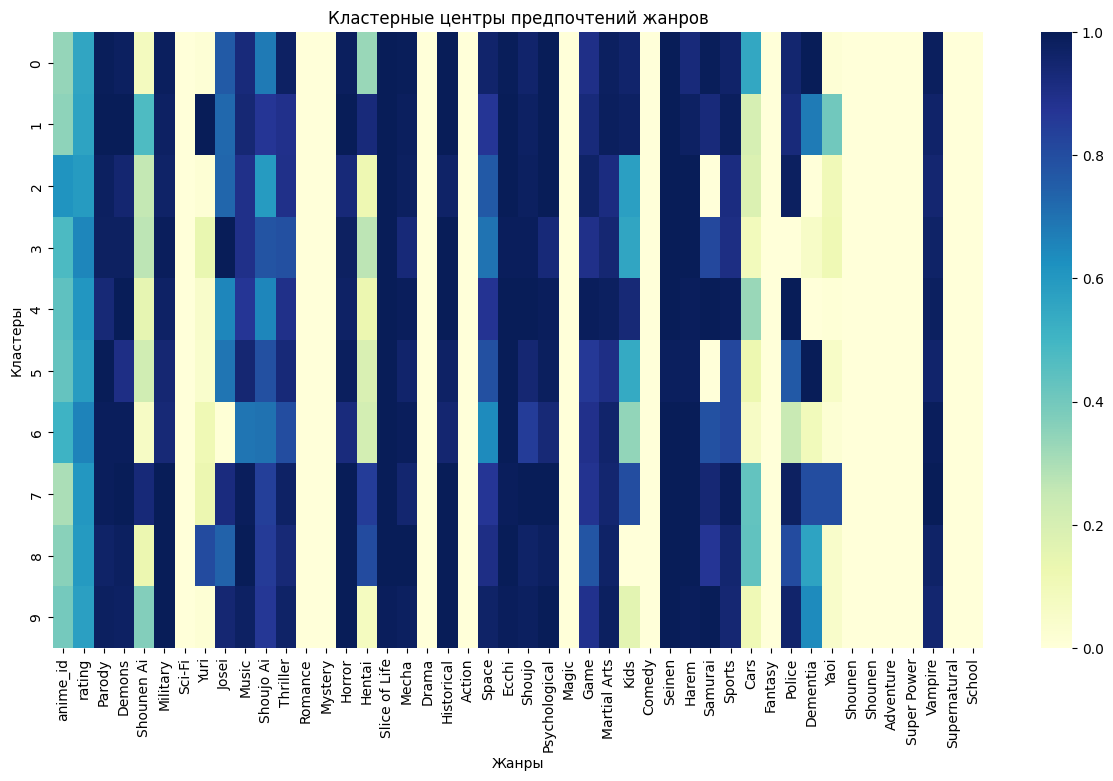

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centers = kmeans.cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=df.columns)

plt.figure(figsize=(15, 8))

sns.heatmap(cluster_centers_df, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Кластерные центры предпочтений жанров")
plt.xlabel("Жанры")
plt.ylabel("Кластеры")
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

100%|█████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 76.24it/s]


Text(0, 0.5, '$J(C_k)$')

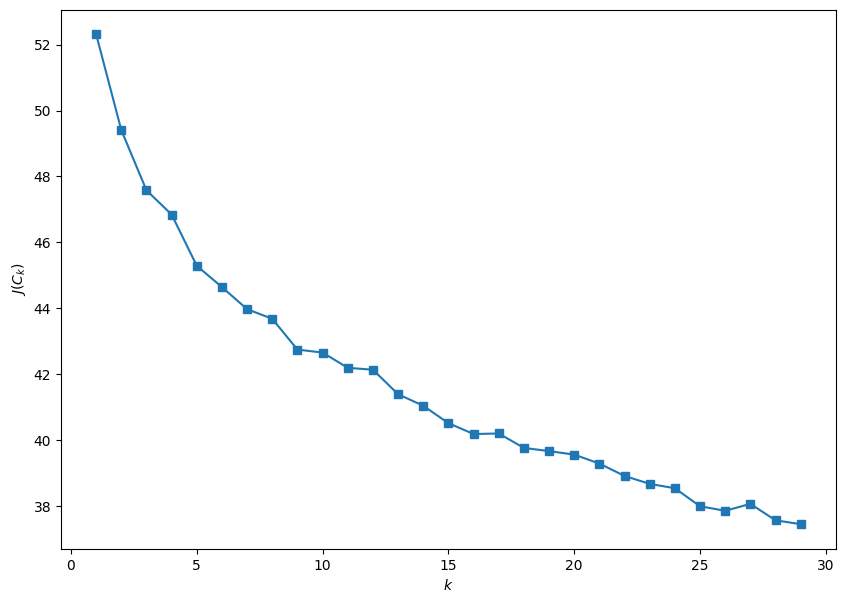

In [22]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [23]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

100%|█████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.91it/s]


29

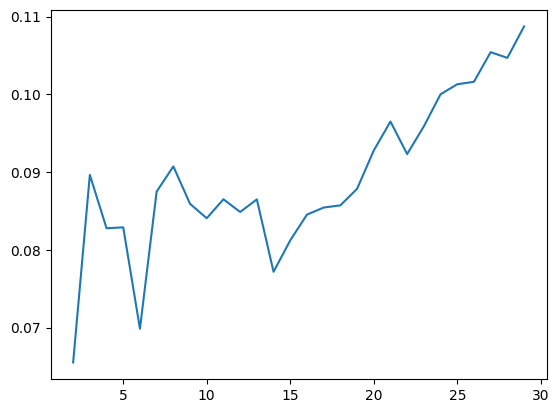

In [24]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.78it/s]


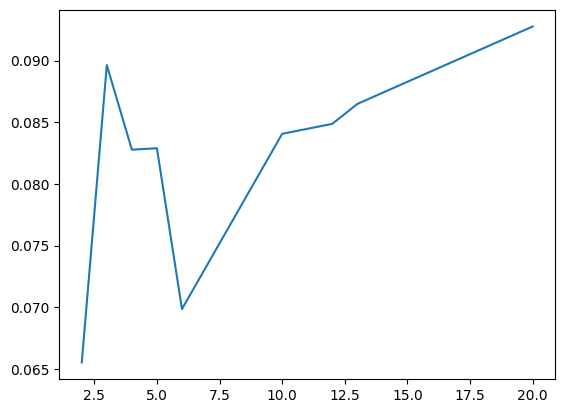

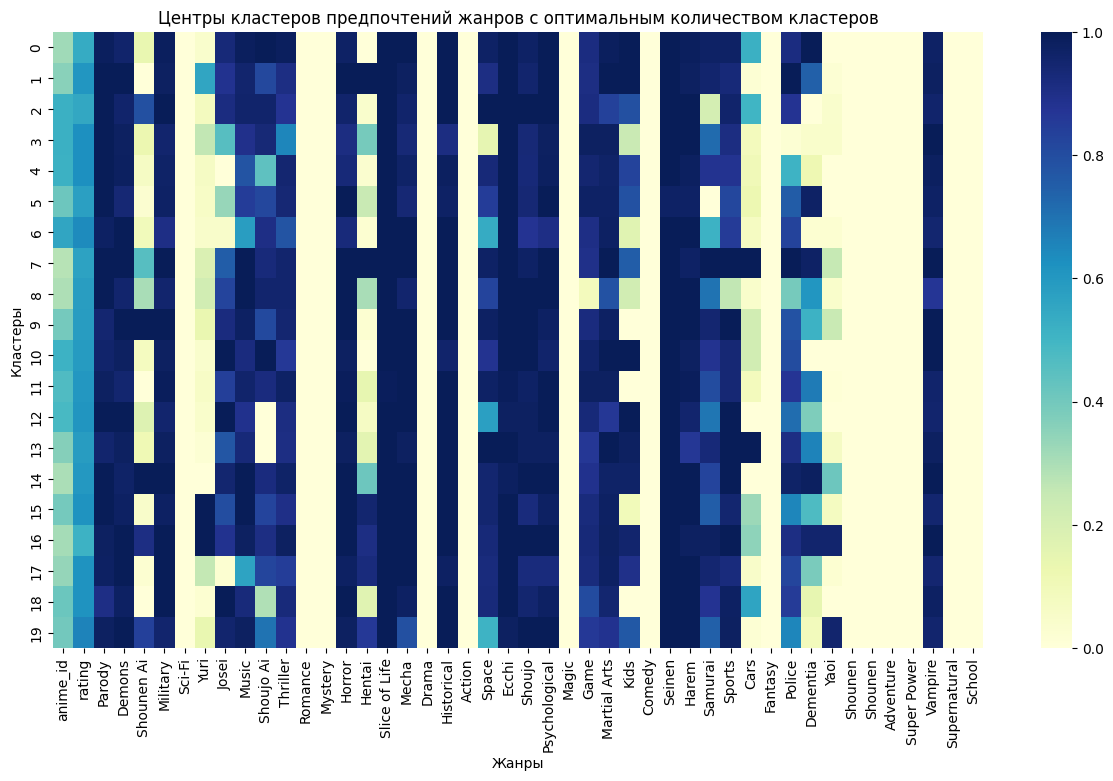

In [25]:
optimal_k = draw_sil_score(df)

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(df)

cluster_centers_optimal_df = pd.DataFrame(kmeans_optimal.cluster_centers_, columns=df.columns)

plt.figure(figsize=(15, 8))
sns.heatmap(cluster_centers_optimal_df, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Центры кластеров предпочтений жанров с оптимальным количеством кластеров")
plt.xlabel("Жанры")
plt.ylabel("Кластеры")
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю. 
Это можно сделать разными способами. Как это сделать подумайте сами. 

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен. 
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [26]:
unique_labels, label_counts = np.unique(kmeans_optimal.labels_, return_counts=True)

most_popular_cluster = unique_labels[np.argmax(label_counts)]

top_genres = cluster_centers_optimal_df.loc[most_popular_cluster].sort_values(ascending=False).index[:5]

print("Топ-5 жанров кластера:", top_genres)

recommended_anime = anime[anime['genre'].apply(lambda x: any(genre in x for genre in top_genres))]

recommended_anime_sorted = recommended_anime.sort_values(by='rating', ascending=False)

print("Рекомендованные аниме:")
print(recommended_anime_sorted[['name', 'genre', 'rating']].head(10))

Топ-5 жанров кластера: Index(['Historical', 'Mecha', 'Seinen', 'Psychological', 'Military'], dtype='object')
Рекомендованные аниме:
                                                       name  \
anime_id                                                      
33607                                          Kahei no Umi   
28977                                              Gintama°   
9969                                          Gintama&#039;   
820                                    Ginga Eiyuu Densetsu   
15417                              Gintama&#039;: Enchousen   
15335     Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   
32627                                      Shaka no Shougai   
26145                                     Okaachan Gomen ne   
24701                         Mushishi Zoku Shou 2nd Season   
44        Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   

                                                      genre  rating  
anime_id                                 

### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

In [ ]:
###  Ваш код или рассуждение или все вместе ### 